### Group 8
- Nimrod Grandpierre
- Jonas Riber Jørgensen
- Johan Ulstrup
- Laura Fur

# Project 4: Tree Comparison

This project is about comparing evolutionary trees constructed using the Neighbor Joining (NJ) methods on different datasets. The objective is to implement an efficient algorithm for computing the RF distance between two trees and use this implementation in an experiment.

## <span style="color:cornflowerblue">Problem<span/>

You should implement an algorithm for computing the RF distance between two unrooted evolutionary trees over the same set of species. The algorithm can e.g. be Day's algorithm as explained in class. You should make a program called ```rfdist``` which as input takes two evolutionary trees in Newick format (also referred to as 'New Hampshire format'), and outputs the RF distance between them.

The archive testdata.zip contains two trees with RF-distance 8. These can e.g. be used for testing.

In [1]:
from Bio import Phylo
import random
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from simulate_trees import *

### **Implementation**

In [5]:
def rfdist(T1: object, T2: object) -> int:
    
    """ Part 1: Rooting the trees """

    # Default root is the first sequence in tree 1 that is also found in tree 2.
    # Assumption: at least one sequence is shared between the two trees.
    
    seqNames_T1 = np.array([leaf.name for leaf in T1.get_terminals()])
    seqNames_T2 = np.array([leaf.name for leaf in T2.get_terminals()])

    rootName = None
    for i in seqNames_T1:
        if i in seqNames_T2:
            rootName = i
            break
    
    # Root trees with selected root:
    T1.root_with_outgroup(rootName)
    T2.root_with_outgroup(rootName)

    # Remove root from tree (for convenience):
    T1.prune(rootName)
    T2.prune(rootName)

    """ Part 2: Depth-first numbering """

    # Tree 1:
    numberedLeaves_T1 = {leaf.name: i for i, leaf in enumerate(T1.get_terminals(), start = 1)}

    # Tree 2:
    numberedLeaves_T2 = {} 
    labeller = 1                                                    
    for leaf in T2.get_terminals():
        if leaf.name in numberedLeaves_T1.keys():
            numberedLeaves_T2[leaf.name] = numberedLeaves_T1[leaf.name]
        else:                                                                               
            numberedLeaves_T2[leaf.name] = max(numberedLeaves_T1.values()) + labeller  # In case tree 2 has sequences not present in tree 1, we also label those.
            labeller += 1

    """ Part 3: Identifying individual and shared tree splits """

    def get_splits(tree: object, numberedLeaves: dict, tree1 = False, tree2 = False):
        intervals = []
        potentially_sharedSplits = []

        for clade in tree.find_clades(order = 'postorder'):
            if not clade.is_terminal():
                leaf_numbers = [numberedLeaves[leaf.name] for leaf in clade.get_terminals()]
                min_leaf = min(leaf_numbers)
                max_leaf = max(leaf_numbers)
                intervals.append((min_leaf, max_leaf))

                if tree2 and max_leaf - min_leaf == len(leaf_numbers) - 1: # Checks if leaf numbers in a clade are consecutive. If so, we consider this a potentially shared split.
                    potentially_sharedSplits.append((min_leaf, max_leaf))

        if tree1:
            return intervals
        elif tree2:
            return intervals, potentially_sharedSplits
        else:
            return None

    T1_splits = get_splits(T1, numberedLeaves = numberedLeaves_T1, tree1 = True)
    T2_splits, potentially_sharedSplits = get_splits(T2, numberedLeaves = numberedLeaves_T2, tree2 = True)

    # print(f'\033[1mTree 1 splits:\033[0m {T1_splits}')
    # print(f'\033[1mTree 2 splits:\033[0m {T2_splits}')
    # print(f'\033[1mPotentially shared splits:\033[0m {potentially_sharedSplits}')

    """ Part 4: Calculating the RF distance """
    sharedSplits = set(T1_splits).intersection(potentially_sharedSplits) # Get overlaping splits

    # print(f'\033[1mActually shared splits:\033[0m {sharedSplits}')

    RF_distance = len(T1_splits) + len(T2_splits) - 2 * len(sharedSplits)

    return RF_distance

#### ```rfdist()```

The function consists of four main parts:

**1. Rooting the unrooted input trees.** The input trees are read using the ```read()``` function from the Phylo module. The default root is the first sequence in the first tree that is also found in the second tree (if they have shared sequences), when traversing the trees. The root is removed from the tree again, for convenience. In case the second tree does not contain any of the same sequences in the first tree, it remains unchanged.

**2. Depth-first numbering.** The names of all sequences present in the first tree are inserted in a dictionary and numbered in the order they are found in the tree when traversing. The sequences in the second tree are also labeled based on the values in the dictionary given to the sequences common between the two trees. In case the second tree contains other sequences than those found in the first tree, they are also labeled accordingly, counting from the last number labeled to a sequence in the first tree.

**3. Identifying tree splits.** To identify tree splits, we use the function, ```get_splits()```, which takes four aguments: ```tree``` - a Phylo tree, ```numberedLeaves``` - a dictionary with original leaf names (as keys) and their new labels after depth-first numbering (as values), ```tree1``` and ```tree2```, for which you can specify if you are getting splits for the first or second tree (default for both is ```False```). If not specified, the function returns ```None```.

 The function identifies leaves in clades, gets their depth-first numbered label and puts these labels in a list, ```leaf_numbers```. From this list, the function finds the minimum and maximum value to make an 'interval'. For the second tree, these intervals might not always be from a clade with consecutively numbered leaves, because it simply finds the minimum and maximum value of this list. We make use of the fact that the clades in the first tree have consecutively numbered leaves to identify potentially shared splits (intervals) with the second tree and then identify the actually shared splits by finding the unique intervals in the first tree that intersect with the potentially shared intervals found in the second tree.

**4. Calculating the RF distance** based on the splits and shared splits identified in part 3. The RF distance is then calculated from the following formula: 

**<span style='color:lightskyblue'>RF distance = (number of splits in T1) + (number of splits in T2) - 2 * (number of common splits between T1 and T2)<span/>**

## <span style="color:cornflowerblue">Tests<span/>
>The function seems to work as intended, judging from running the algorithm on the provided test data:

In [3]:
tree1 = Phylo.read('Testdata/tree1.new', 'newick')
tree2 = Phylo.read('Testdata/tree2.new', 'newick')

print(f'\033[1mRF distance:\033[0m {rfdist(tree1, tree2)}')

Tree 1 splits: [(2, 3), (5, 6), (4, 6), (2, 6), (2, 7), (1, 7), (8, 9), (1, 9)]
Tree 2 splits: [(8, 9), (4, 9), (1, 9), (1, 9), (2, 3), (1, 9), (5, 6), (1, 9)]
Potentially shared splits: [(8, 9), (2, 3), (5, 6), (1, 9)]
Actually shared splits: {(2, 3), (1, 9), (8, 9), (5, 6)}
RF distance: 8


>and our own testdata:

In [4]:
treeA = Phylo.read('Testdata/Randomtrees/treeA_len_10.new', 'newick')
treeB = Phylo.read('Testdata/Randomtrees/treeB_len_10.new', 'newick')

print(f'\033[1mRF distance:\033[0m {rfdist(treeA, treeB)}')

Tree 1 splits: [(2, 3), (1, 3), (5, 6), (5, 7), (5, 8), (4, 8), (1, 8), (1, 9)]
Tree 2 splits: [(12, 13), (12, 14), (11, 14), (10, 14), (17, 18), (16, 18), (15, 18), (10, 18)]
Potentially shared splits: [(12, 13), (12, 14), (11, 14), (10, 14), (17, 18), (16, 18), (15, 18), (10, 18)]
Actually shared splits: set()
RF distance: 16


>These trees are completely different, containing no identical sequences. The algorithm correctly identifies no actually shared splits. 

>**NOTE** that the print statements have been commented out for the experiments.

#### **Time complexity analysis of** ```rfdist()```
Simulating trees of different sizes - the largest tree containing 1000 sequences - in Newick format (see simulate_trees.py file for script):

In [6]:
random.seed(8)

for i in ['treeA', 'treeB']:
    for tree_len in range(2, 1001):
        tree = generate_tree(tree_len, set())
        write_newick(tree, f'Testdata/Randomtrees/{i}_len_{tree_len}.new')

Measuring running time:

In [7]:
treeA_list = sorted([file for file in os.listdir('Testdata/Randomtrees') if file.startswith('treeA')], key = lambda s: int(s.split('_')[2].split('.')[0]))
treeB_list = sorted([file for file in os.listdir('Testdata/Randomtrees') if file.startswith('treeB')], key = lambda s: int(s.split('_')[2].split('.')[0]))

tree_sizes = np.arange(2, 1001)
exec_times = np.zeros(len(tree_sizes))

for i in range(2, len(tree_sizes)):
    treeA = Phylo.read(f'Testdata/Randomtrees/{treeA_list[i]}', 'newick')
    treeB = Phylo.read(f'Testdata/Randomtrees/{treeB_list[i]}', 'newick')

    start_time = time.time()

    rfdist(treeA, treeB)

    end_time = time.time()
    exec_times[i] = end_time - start_time

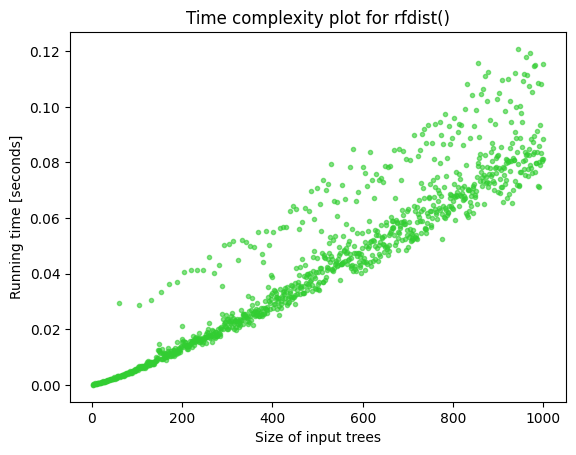

In [8]:
df = pd.DataFrame({'tree_size': tree_sizes, 'exec_time': exec_times})

plt.scatter(df['tree_size'], df['exec_time'], color = 'limegreen', marker = '.', alpha = 0.6)
plt.xlabel('Size of input trees')
plt.ylabel('Running time [seconds]')
plt.title('Time complexity plot for rfdist()')
plt.grid(False)
plt.show()

>From the above time complexity plot, it is confirmed that the algorithm runs in approximately linear time (at least for trees containing 2-1000 sequences), as intended. Both 'scatter clouds' are approximately linear. The fact that we observe _two_ 'scatter clouds' and that the scatter clouds become less 'dense' as the size of the input trees increases could indicate that the running time is also dependent on how different the trees are - i.e., how many sequences they share, relative to their size, and due to memory allocation or random CPU fluctuations. However, this difference in running time can be considered negligible, looking at the y axis. Data is simple enough that we do not see a steep increase in running time.

>**NOTE**: the time complexity is only analyzed for when the two trees have the same number of sequences.

## <span style="color:cornflowerblue">Experiments<span/>
The programs QuickTree and RapidNJ are implementations of the NJ methods. QuickTree implements the basic cubic time algorithm while RapidNJ implements an algorithm the is faster in practice. You might want to take a look at the QuickTree paper and the RapidNJ paper.

Downloading quicktree_2.0.tar.gz and rapidnj-src-2.3.3.zip and compiling on a Linux-platform is straightforward (just run 'make'). 

The file patbase_aibtas.fasta contains 395 protein sequences from the P-Type ATPase Database in Fasta-format.

You should make an experiment where you first construct a number of trees for these 395 sequences using NJ (as implemented in QuickTree and RapidNJ) based on different multiple alignments of the 395 sequences, and secondly, compare the construted trees using your program rfdist in order to investigate the influence of using different multiple alignment methods and tree reconstruction methods. Biologically, the 395 sequences are grouped into five groups. The group which a sequenence belongs to is indicated by the first character (1-5) in its name in Fasta-file. If you visualize your constructed trees using e.g. the program Dendroscope, you might want to inspect to what extend sequences from one group are in the same subtree.

The alignment methods you most use are:

- Clustal Omega: https://www.ebi.ac.uk/jdispatcher/msa/clustalo
- Kalign: https://www.ebi.ac.uk/jdispatcher/msa/kalign
- MUSCLE: https://www.ebi.ac.uk/jdispatcher/msa/muscle

You should use the default parameters of each program. Beware of the output format. QuickTree can only read multiple alignments in Stockholm-format, and RapidNJ can read multiple alignments in both Fasta- and single line Stockholm-format.

Converting to Stockholm-format: You can use the online converter available at http://hcv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html to convert different alignment formats to Stockholm- and Fasta-format. To convert to single line Stockholm-format, you must set the 'Output line width' to 'as wide as possible'. Update (Apr 2021): It seems that QuickTree 2.0 cannot read the Stockholm-format produced by the online converter. The problem is that the Stockholm-file constructed by the online converter starts with the line "# STOCKHOLM 1.0" follow by an empty line. If you remove these two lines, then QuickTree 2.0 can read the file. I do not know when this "bug" was introduced, but it used to work ;-)

### **Experiment 1**
*For each alignment method (Clustal Omega, Kalign, MUSCLE), you build a NJ tree using QuickTree and RapidNJ, and compute the RF-distance between each combination of these six trees. The outcome of your experiment, is an 6x6 table showing the RF-distance between each pair of constructed trees. (You might want to use the program Dendroscope to visualize the constructed trees.)*

In [9]:
tree_list = sorted([file for file in os.listdir('alignments_newicks') if file.endswith('.newick')], key = lambda s: sum(map(ord, s)))

rfdists = [[0] * len(tree_list) for _ in range(len(tree_list))]

for i, treeA_file in enumerate(tree_list):
    for j, treeB_file in enumerate(tree_list):
        if i != j:
            treeA = Phylo.read(f'alignments_newicks/{treeA_file}', 'newick')
            treeB = Phylo.read(f'alignments_newicks/{treeB_file}', 'newick')
            rfdists[i][j] = rfdist(treeA, treeB)

labels = [file[:-7] for file in tree_list]
pd.DataFrame(rfdists, index = labels, columns = labels)

,kalign.rapidNJ,muscle.rapidnj,clustal.rapidnj,kalign.quicktree,muscle.quicktree,clustal.quicktree
kalign.rapidNJ,0,286,274,232,318,290
muscle.rapidnj,286,0,242,298,192,246
clustal.rapidnj,274,242,0,296,284,230
kalign.quicktree,232,298,296,0,264,206
muscle.quicktree,318,192,284,264,0,198
clustal.quicktree,290,246,230,206,198,0


>The newick files from the alignments generated with the alignment tools for the non-permuted data can be found in the 'alignments_newicks' folder.

### **Experiment 2**
*Redo the above experiment where you use 395 input sequences in patbase_aibtas_permuted.fasta. This yields another 6x6 table.*

In [10]:
tree_list = sorted([file for file in os.listdir('permuted/permuted_newicks')], key = lambda s: sum(map(ord, s)))

num_trees = len(tree_list)
rfdists = [[0] * num_trees for _ in range(num_trees)]

for i, treeA_file in enumerate(tree_list):
    for j, treeB_file in enumerate(tree_list):
        if i != j:
            treeA = Phylo.read(f'permuted/permuted_newicks/{treeA_file}', 'newick')
            treeB = Phylo.read(f'permuted/permuted_newicks/{treeB_file}', 'newick')
            rfdists[i][j] = rfdist(treeA, treeB)

labels = [file[:-7] for file in tree_list]
pd.DataFrame(rfdists, index = labels, columns = labels)

,kalign.permuted.rapidnj,muscle.permuted.rapidnj,clustal.permuted.rapidnj,kalign.permuted.quicktree,muscle.permuted.quicktree,clustal.permuted.quicktree
kalign.permuted.rapidnj,0,268,280,226,298,288
muscle.permuted.rapidnj,268,0,246,284,208,216
clustal.permuted.rapidnj,280,246,0,298,280,238
kalign.permuted.quicktree,226,284,298,0,224,198
muscle.permuted.quicktree,298,208,280,224,0,158
clustal.permuted.quicktree,288,216,238,198,158,0


>The newick files from the alignments generated with the alignment tools for the permuted data can be found in the 'permuted_newicks' subfolder in the 'permuted' parent folder.

### **Experiment 3**
*Compute the RF-distance between the trees produced in 'Experiment 1' and 'Experiment 2' using the same alignment and tree reconstruction method. This yields 6 distances.*

In [11]:
nonpermuted = sorted([file for file in os.listdir('alignments_newicks') if file.endswith('.newick')], key = lambda s: sum(map(ord, s)))
permuted = sorted([file for file in os.listdir('permuted/permuted_newicks')], key = lambda s: sum(map(ord, s)))

rfdists = []

for i in range(len(nonpermuted)):
    treeA = Phylo.read(f'alignments_newicks/{nonpermuted[i]}', 'newick')
    treeB = Phylo.read(f'permuted/permuted_newicks/{permuted[i]}', 'newick')
    rfdists.append(rfdist(treeA, treeB))

labels = [f'{file[:-17].capitalize()} - QuickTree' if file.endswith('quicktree.newick') else f'{file[:-15].capitalize()} - RapidNJ' for file in nonpermuted]
pd.DataFrame([rfdists], index = ['RF distance'], columns = labels)

,Kalign - RapidNJ,Muscle - RapidNJ,Clustal - RapidNJ,Kalign - QuickTree,Muscle - QuickTree,Clustal - QuickTree
RF distance,264,216,160,172,158,68


## <span style='color:cornflowerblue'>Conclusion<span/>
>We have successfully implemented the ```rfdist()``` function in Python and conducted the experiments outlined in the project description. The algorithm works as intended when using testdata and approximately runs in linear time.